# AmBe Data
The AmBe data was taken with the 9Li trigger. We launch 1820 readout windows, each of them 270 $\mu s$ long with 7 $\mu s$ between them, after those 1820
windows, we wait 20 (or whatever) seconds, and then another burst of 1820 windows.

7 $\mu s$ = 7e3 ns\
20 s       = 2e10 ns = 2e7 $\mu s$


In [2]:
import sys
import os

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/2025_data"))
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger"))
sys.path.append('/eos/home-d/dcostasr/SWAN_projects/software/hipy')
sys.path.append("/eos/home-d/dcostasr/SWAN_projects/software/wcte_software/")

import hipy.pltext       as pltext
import hipy.utils        as ut
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np
import matplotlib.colors as colors

from src.read_data                   import load_concatenated, read_parquet, nHits
from tqdm.notebook                   import tqdm
from WCTE_event_display.EventDisplay import EventDisplay
from scipy.special import factorial


%load_ext autoreload
%autoreload 2

pltext.style()

## Read Data

In [52]:
# ============= LOADS THE DATA ===================
run  = 2384
data = load_concatenated(outdir=f"/eos/home-d/dcostasr/SWAN_projects/AmBe/tmp_parquet/{run}")

In [53]:
# =============== MASK OUT CARDS 130-132 ===================
run_cards, run_channels, run_slots, run_positions, run_times, run_events, run_charges, run_window_times = read_parquet(data, mask=True)

In [54]:
run_times_sorted = ak.sort(run_times) - run_window_times

In [55]:
run_window_times_sorted = ak.sort(run_window_times, axis=0)

## Check That Data Makes Sense. I.E.: Separation between bunches is 20 s and separation between windows is 7 $\mu s$

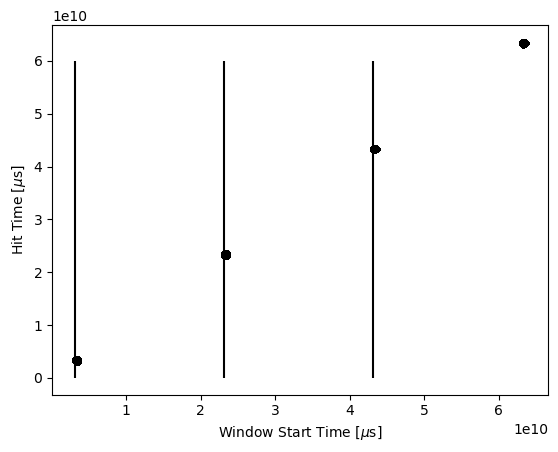

In [28]:
plt.scatter(ak.ravel(run_window_times), ak.ravel(run_times), marker=".");
plt.ylabel("Hit Time [$\mu$s]");
plt.xlabel("Window Start Time [$\mu$s]");

plt.vlines(ak.sort(run_window_times)[0][0], 0, 6e10);
plt.vlines(run_window_times[0][0]+2e10, 0, 6e10);
plt.vlines(run_window_times[0][0]+4e10, 0, 6e10);

# plt.xlim(0.3e10, 0.37e10);
# plt.ylim(0.3e10, 0.37e10);

Time Between Windows 277.752
Lenght Of the Window 173.7147577724457


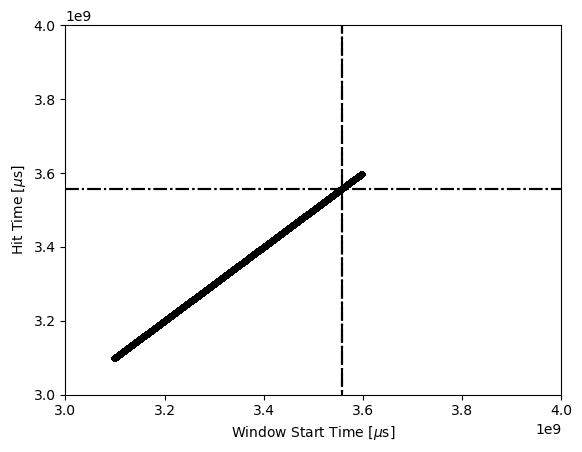

In [36]:
plt.scatter(ak.ravel(run_window_times), ak.ravel(run_times), marker=".");
plt.ylabel("Hit Time [$\mu$s]");
plt.xlabel("Window Start Time [$\mu$s]");

plt.vlines(ak.sort(run_window_times)[0][0], 0, 6e10, linestyle="-.");
plt.vlines(ak.sort(run_window_times)[0][0]+2.7e5, 0, 6e10, linestyle="-.");
plt.vlines(ak.sort(run_window_times)[0][0]+2.7e5+7e3, 0, 6e10, linestyle="--");

plt.hlines(ak.sort(run_times)[0][0], 0, 6e10, linestyle="-.");
plt.hlines(ak.sort(run_times)[0][0]+2.7e5, 0, 6e10, linestyle="-.");

# plt.xlim(0.309805e10, 0.30985e10);
# plt.ylim(0.30980e10, 0.309875e10);

plt.xlim(0.3e10, 0.4e10);
plt.ylim(0.3e10, 0.4e10);

print("Time Between Windows", (run_window_times[1][0] - run_window_times[0][0])*1e-3)
print("Lenght Of the Window", (run_times[0][-1] - run_times[0][0])*1e-3)

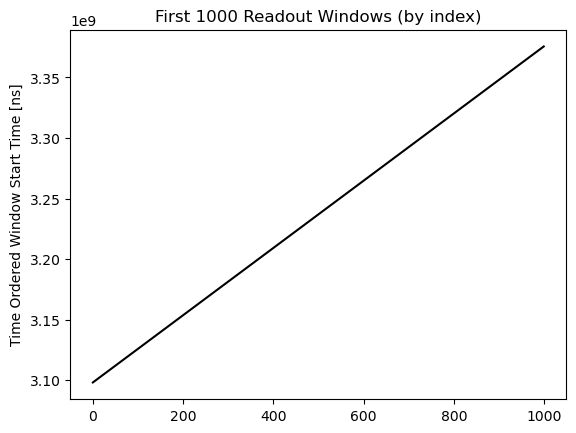

In [49]:
plt.plot(run_window_times_sorted[:,0][:1000]);
plt.ylabel("Time Ordered Window Start Time [ns]");
plt.title("First 1000 Readout Windows (by index)");

## Looking At Readout Windows

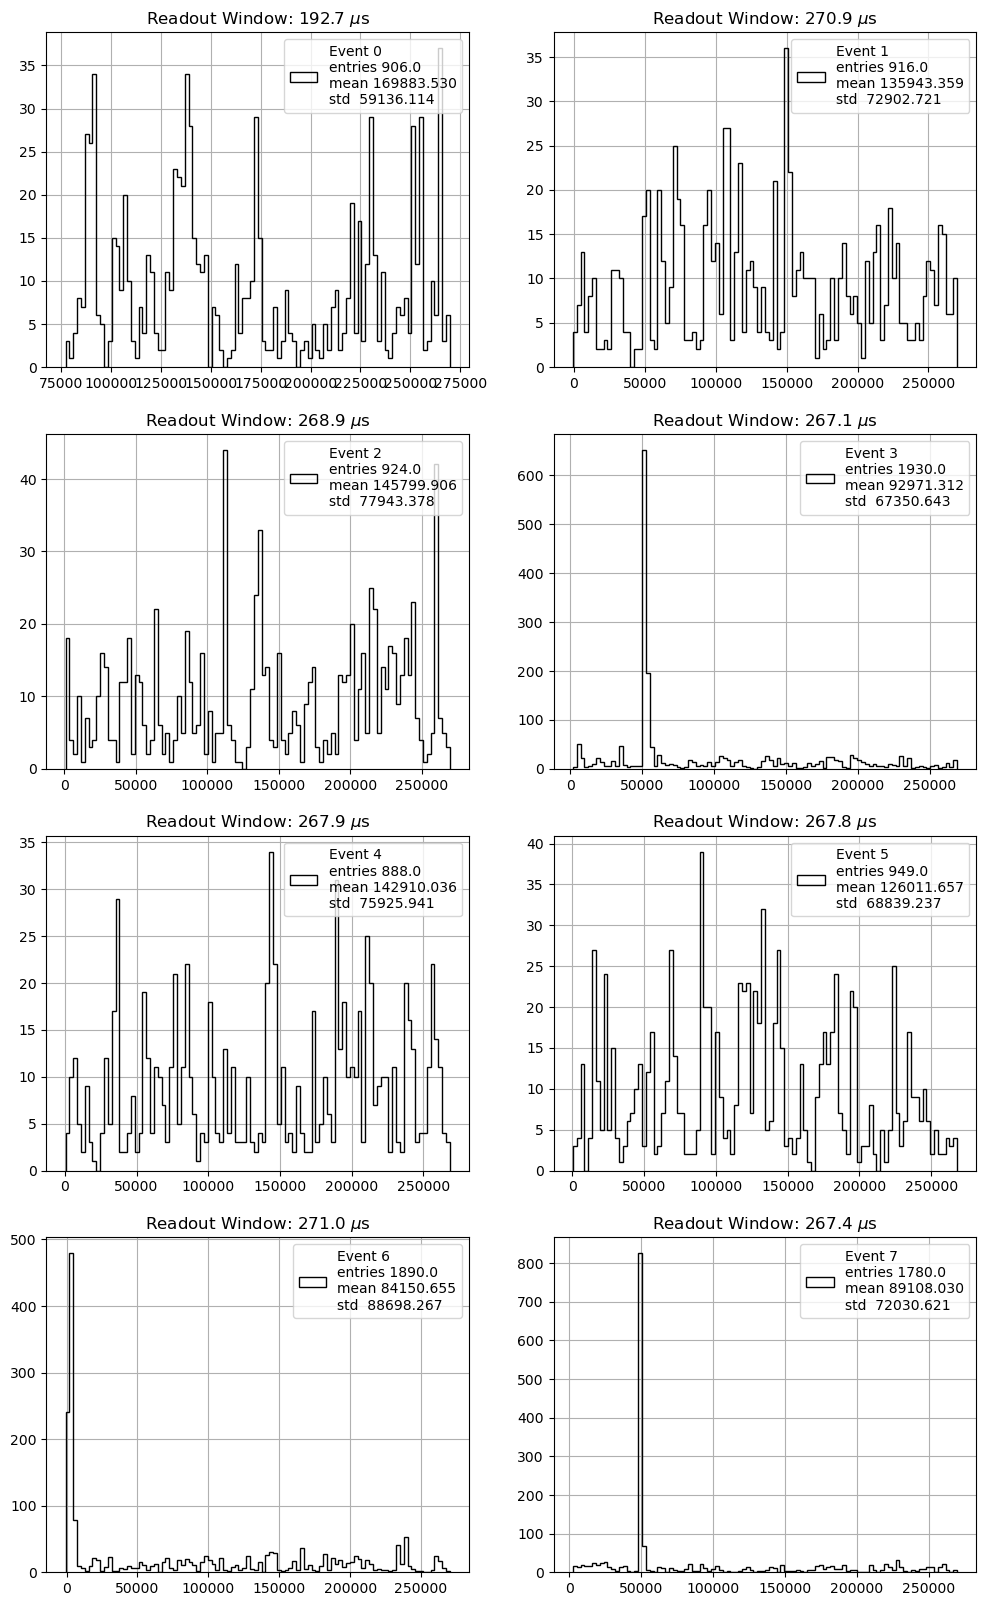

In [122]:
subplot = pltext.canvas(8)

for i,event in enumerate(range(8)):
    subplot(i+1)
    pltext.hist(run_times_sorted[event], 100, label=f"Event {event}");
    plt.title(f"Readout Window: {(run_times_sorted[event][-1] - run_times_sorted[event][0])*1e-3:.1f} $\mu$s")

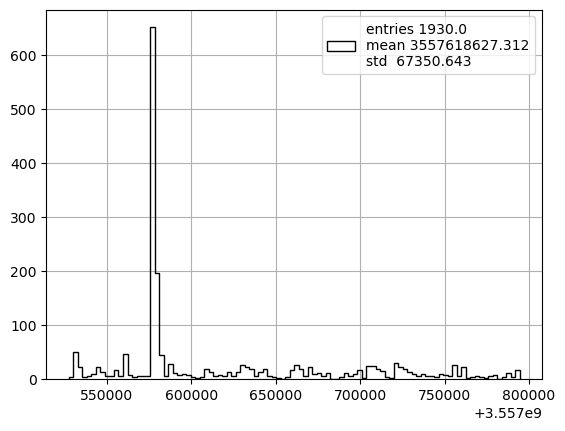

In [10]:
data = run_times[3]
hist_range=(3.557e9+577000, 3.557e9+578500)
indices_in_range = np.where((data >= hist_range[0]) & (data <= hist_range[1]))[0]

pltext.hist(data, 100, range=None);
# plt.title(f"Window Lenght: {data[indices_in_range][-1] - data[indices_in_range][0]:.2f} ns. {len(data[indices_in_range])} Hits");

### Event Display

(2014,)


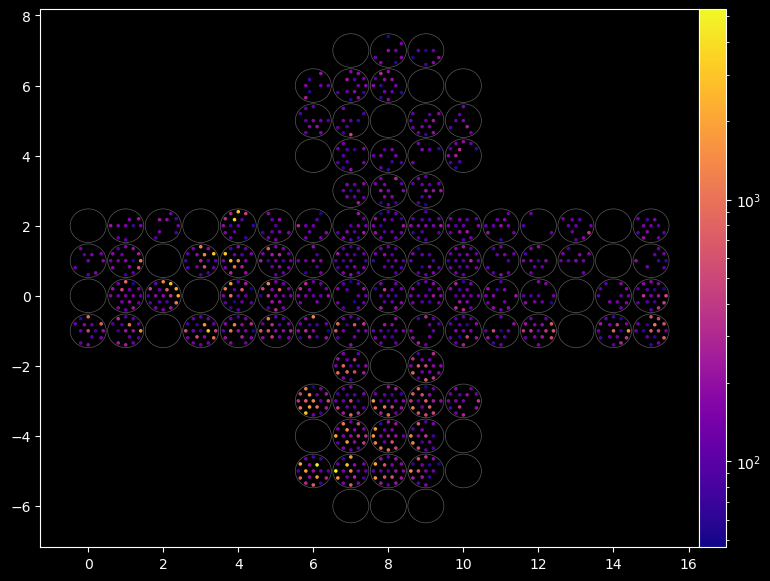

In [9]:
event = 6
pmt_id = (run_slots[event]*19 + run_positions[event])
data_to_plot = run_charges[event]#[indices_in_range]

eventDisplay = EventDisplay() 
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')

ev_disp_data = eventDisplay.process_data(pmt_id, data_to_plot, sum_data=False)
eventDisplay.plotEventDisplay(ev_disp_data, color_norm=colors.LogNorm(), style="dark_background", fig_width=10)

plt.show(block=False)
plt.style.use('default');

pltext.style()

# nHits To Find Spills and AfterPulsing

In [56]:
triggered_spill_hits_index = nHits(mode="multiple_events", hit_times=run_times_sorted, w=5000, thresh_min=100, thresh_max=10000, pre_window=0, post_window=4000, jump=9000)

100%|██████████| 157955/157955 [00:49<00:00, 3175.36it/s]


In [9]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("./nHits_Spills.pdf") as pdf:
    for key, value in tqdm(triggered_spill_hits_index.items(), total=len(triggered_spill_hits_index.items())):
        event = key
        data = run_times_sorted[event]
        pltext.hist(data,                                                        100, range=(data[0], data[-1]), label=f"Event {event}");
        pltext.hist(data[np.concatenate(triggered_spill_hits_index.get(event))], 100, range=(data[0], data[-1]), label="Triggered Hits");
        
        plt.title(f"Readout Window: {(data[-1] - data[0])*1e-3:.1f} $\mu$s")

        pdf.savefig()  
        plt.close()

NameError: name 'triggered_spill_hits_index' is not defined

This seems to work quite well. Now is time to remove those hits from the readout windows

In [57]:
noSpill_hit_times = []
for key, value in tqdm(triggered_spill_hits_index.items(), total=len(triggered_spill_hits_index)):
    event = key
    data  = run_times_sorted[event]
    trigger_indices = np.concatenate(triggered_spill_hits_index.get(event))
    all_indices     = np.arange(len(data))
    invalid_indices = np.setdiff1d(all_indices, trigger_indices)
    noSpill_hit_times.append(data[invalid_indices])

noSpill_hit_times = ak.Array(noSpill_hit_times)

  0%|          | 0/64011 [00:00<?, ?it/s]

Agora preciso atopar os eventos que o nHits para atopar Spills non está tendo en conta

In [58]:
total_events = np.arange(len(run_times_sorted))
spill_events = [key for key,value in tqdm(triggered_spill_hits_index.items(), total=len(triggered_spill_hits_index))]

noSpill_events = [i for i in tqdm(total_events, total=len(total_events)) if i not in spill_events]

  0%|          | 0/64011 [00:00<?, ?it/s]

  0%|          | 0/157955 [00:00<?, ?it/s]

In [59]:
corrected_run_times_sorted = ak.sort(ak.concatenate([run_times_sorted[noSpill_events], noSpill_hit_times], axis=0))

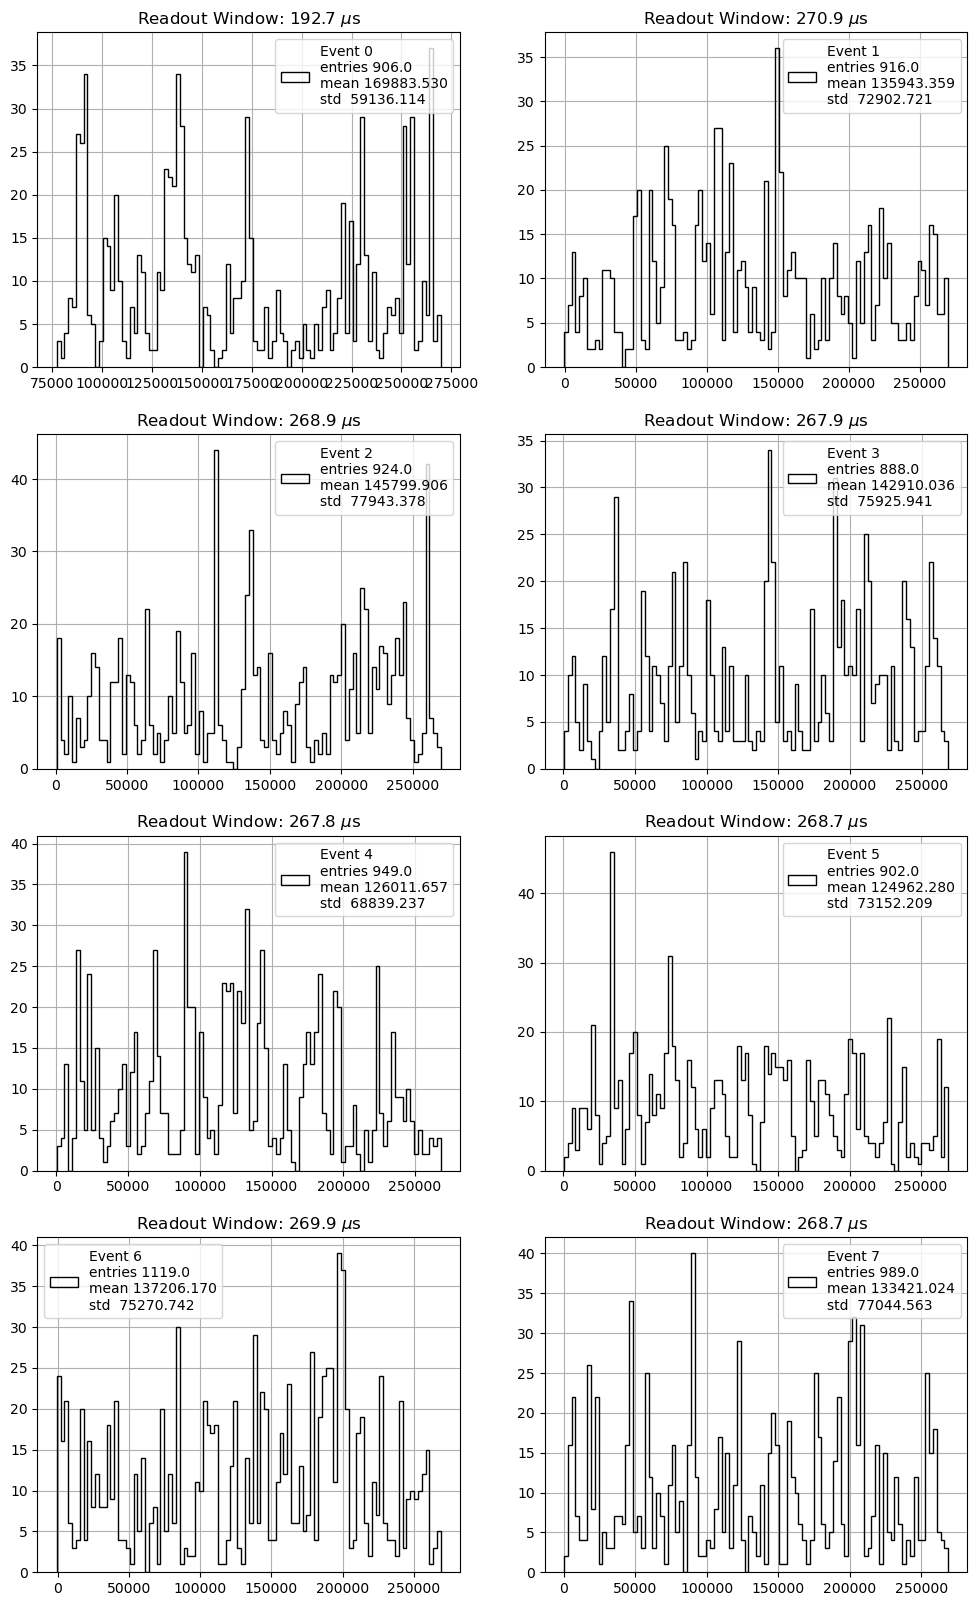

In [ ]:
subplot = pltext.canvas(8)

for i,event in enumerate(range(8)):
    subplot(i+1)
    data = corrected_run_times_sorted[event]
    pltext.hist(data, 100, label=f"Event {event}");
    plt.title(f"Readout Window: {(data[-1] - data[0])*1e-3:.1f} $\mu$s")

# nHits To Find Scintillation
We know Scintillation should come in a ~1.5 $\mu s$ window 

In [60]:
triggered_scint_hits_index = nHits(mode="multiple_events", hit_times=corrected_run_times_sorted, event=event, w=1500, thresh_min=70, thresh_max=300, pre_window=500, post_window=500, jump=2500)

100%|██████████| 157955/157955 [00:21<00:00, 7433.77it/s]


In [61]:
len(triggered_scint_hits_index.items())

3791

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("./nHits_Scint.pdf") as pdf:
    for key, value in tqdm(triggered_scint_hits_index.items(), total=len(triggered_scint_hits_index.items())):
        event = key
        data = corrected_run_times_sorted[event]
        pltext.hist(data,                                                        100, range=(data[0], data[-1]), label=f"Event {event}");
        pltext.hist(data[np.concatenate(triggered_scint_hits_index.get(event))], 100, range=(data[0], data[-1]), label="Triggered Hits");
        # plt.title(f"Readout Window: {(run_times_sorted[event][-1] - run_times_sorted[event][0])*1e-3:.1f} $\mu$s")

        pdf.savefig()  
        plt.close() 

  0%|          | 0/111 [00:00<?, ?it/s]

# WorkFlow For Finding Neutron Candidates

In [54]:
triggered_scint_hits_index.keys()

dict_keys([0, 43, 116, 187, 200, 236, 237, 302, 316, 352, 370, 379, 490, 609, 614, 650, 729, 799, 850, 886, 909, 910, 924, 998, 1091, 1126, 1379, 1381, 1519, 1628, 1637, 1718, 1730, 1771, 1807, 1824, 1835, 2054, 2098, 2122, 2133, 2142, 2210, 2237, 2258, 2270, 2278, 2336, 2368, 2442, 2452, 2453, 2507, 2533, 2582, 2731, 2789, 2798, 2866, 3036, 3067, 3099, 3124, 3159, 3238, 3266, 3302, 3516, 3669, 3722, 3745, 3834, 3898, 3900, 3954, 3961, 3993, 4098, 4099, 4142, 4172, 4231, 4233, 4264, 4294, 4326, 4343, 4354, 4416, 4536, 4550, 4588, 4645, 4677, 4765, 4793, 4818, 4885, 4900, 4913, 4959, 4977, 5071, 5105, 5171, 5247, 5283, 5331, 5337, 5420, 5422, 5489, 5578, 5637, 5684, 5806, 5850, 5927, 5928, 5944, 5970, 5972, 5989, 6011, 6020, 6113, 6156, 6167, 6205, 6239, 6243, 6282, 6455, 6460, 6577, 6586, 6628, 6685, 6698, 6762, 6842, 6843, 6879, 6888, 6896, 6908, 6921, 6947, 6983, 7011, 7047, 7069, 7127, 7131, 7144, 7203, 7208, 7233, 7238, 7258, 7343, 7347, 7383, 7409, 7480, 7486, 7504, 7537, 7600, 76

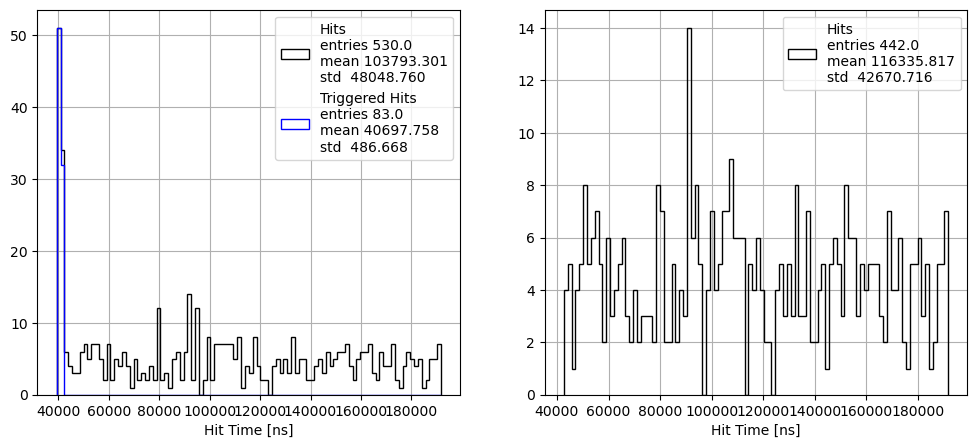

In [56]:
pltext.style()
event = 0
data = corrected_run_times_sorted[event]

subplot = pltext.canvas(2)

hist_range_preSel = (data[np.concatenate(triggered_scint_hits_index.get(event))][0]-500, 
                     data[np.concatenate(triggered_scint_hits_index.get(event))][-1]+150e3)

indices_in_range_preSel = np.where((data >= hist_range_preSel[0]) & (data <= hist_range_preSel[1]))[0]

subplot(1)
pltext.hist(data                                                       , 100, range=hist_range_preSel, ylog=False, label="Hits", xylabels="Hit Time [ns]");
pltext.hist(data[np.concatenate(triggered_scint_hits_index.get(event))], 100, range=hist_range_preSel, ylog=False, label="Triggered Hits");

subplot(2)
hist_range_postSel = (data[np.concatenate(triggered_scint_hits_index.get(event))][-1]+1e3, 
                     data[np.concatenate(triggered_scint_hits_index.get(event))][-1]+150e3)
indices_in_range_postSel = np.where((data > hist_range_postSel[0]) & (data <= hist_range_postSel[1]))[0]

pltext.hist(data                                                 , 100, range=hist_range_postSel, ylog=False, label="Hits", xylabels="Hit Time [ns]");
# plt.vlines(20e3, 0, 50, color="red");
# plt.vlines(20e3+6.5e3, 0, 50, color="red");
# plt.vlines(20e3+6.5e3+65e3, 0, 20, color="blue");

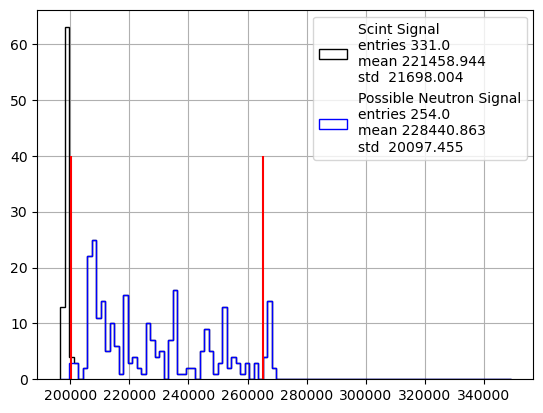

In [184]:
pltext.hist(data[indices_in_range_preSel],  100, range=hist_range_preSel, ylog=False, label="Scint Signal");
pltext.hist(data[indices_in_range_postSel], 100, range=hist_range_preSel, ylog=False, label="Possible Neutron Signal");
plt.vlines(data[indices_in_range_postSel][0], 0, 40, color="red");
plt.vlines(data[indices_in_range_postSel][0]+65e3, 0, 40, color="red");
# plt.vlines(data[indices_in_range_postSel]+3e3, 0, 40, color="red");

In [ ]:
# SINGLE EVENT MODE
thresh_min = 10
thresh_max = 50
w = 100
pre_window = 0
post_window = 0
jump = 0

triggered_neutronCandidate_hits_index = {}

ht = ak.to_numpy(data[indices_in_range_postSel])

# Sliding window logic
ends   = ht + w
right  = np.searchsorted(ht, ends, side="left")
left   = np.arange(len(ht))
counts = right - left

# Get the indices of all the hit times that triggered the nHits algorithm
trigger_indices = np.where((counts >= thresh_min) & (counts < thresh_max))[0]

event_hits = []
last_trigger_time = -np.inf  # First trigger always need to exist

# Search for the rest of the hits in the trigger
for idx in trigger_indices:
    # Define actual sliding window that triggered
    i_start = idx
    i_end = right[idx]  # one past the last hit in window
    window_hits = ht[i_start:i_end]

    first_hit_time = window_hits[0]
    last_hit_time  = window_hits[-1]

    # Avoid overlap due to dead time
    if first_hit_time < last_trigger_time + jump:
        continue

    # Expand window
    t_min = first_hit_time - pre_window
    t_max = last_hit_time + post_window

    indices_in_window = np.where((ht >= t_min) & (ht <= t_max))[0]
    event_hits.append(indices_in_window)

    last_trigger_time = first_hit_time  # or maybe last_hit_time 

# Update dictionary
if len(event_hits) > 0:
    triggered_neutronCandidate_hits_index[event] = event_hits

if len(triggered_neutronCandidate_hits_index) == 0:
    print("No Neutron Candidates Found!")

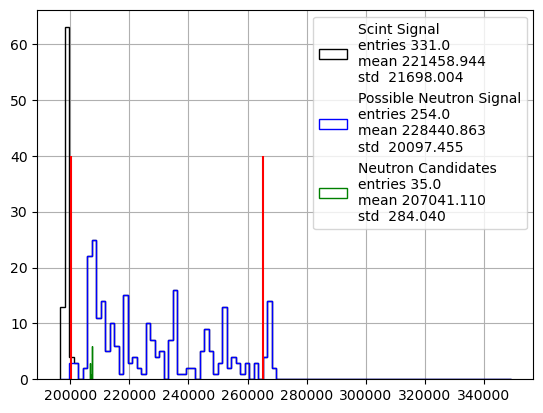

In [186]:
pltext.hist(data[indices_in_range_preSel],  100, range=hist_range_preSel, ylog=False, label="Scint Signal");
pltext.hist(data[indices_in_range_postSel], 100, range=hist_range_preSel, ylog=False, label="Possible Neutron Signal");
pltext.hist(data[indices_in_range_postSel][np.concatenate(triggered_neutronCandidate_hits_index.get(event))], 100, label="Neutron Candidates");

plt.vlines(data[indices_in_range_postSel][0], 0, 40, color="red");
plt.vlines(data[indices_in_range_postSel][0]+65e3, 0, 40, color="red");

In [187]:
neutronCandidate_indices = np.concatenate(triggered_neutronCandidate_hits_index.get(event))

### Event Display

(2014,)


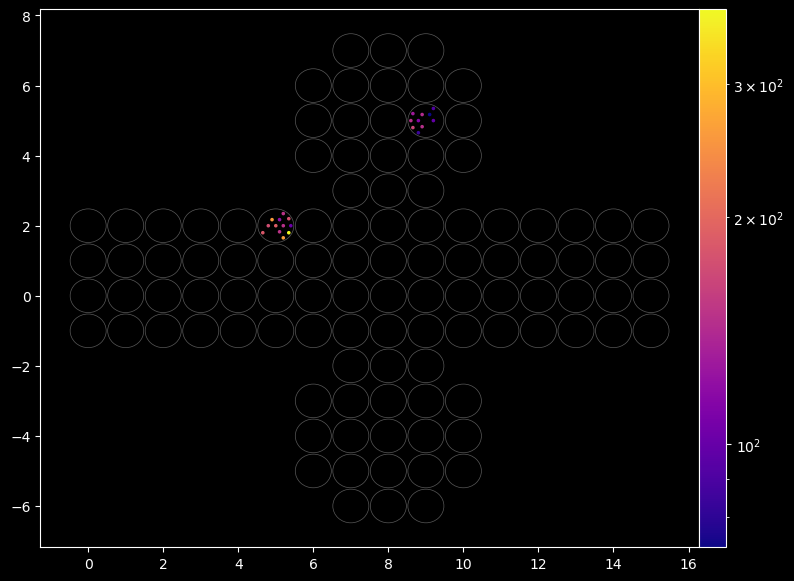

In [188]:
pmt_id = (run_slots[event]*19 + run_positions[event])
data_to_plot = run_charges[event][neutronCandidate_indices]

eventDisplay = EventDisplay() 
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')

ev_disp_data = eventDisplay.process_data(pmt_id, data_to_plot, sum_data=False)
eventDisplay.plotEventDisplay(ev_disp_data, color_norm=colors.LogNorm(), style="dark_background", fig_width=10)

plt.show(block=False)
plt.style.use('default');

# All Together

In [201]:
pltext.style()
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("./nHits_nCandidates.pdf") as pdf:
    for key,values in tqdm(triggered_scint_hits_index.items(), total=len(triggered_scint_hits_index)):
        event = key
        data = corrected_run_times_sorted[event]

        # subplot = pltext.canvas(2)

        hist_range_preSel = (data[np.concatenate(triggered_scint_hits_index.get(event))][0]-500, 
                            data[np.concatenate(triggered_scint_hits_index.get(event))][-1]+150e3)

        indices_in_range_preSel = np.where((data >= hist_range_preSel[0]) & (data <= hist_range_preSel[1]))[0]

        # subplot(1)
        # pltext.hist(data                                                       , 100, range=hist_range_preSel, ylog=False, label="Hits");
        # pltext.hist(data[np.concatenate(triggered_scint_hits_index.get(event))], 100, range=hist_range_preSel, ylog=False, label="Triggered Hits");

        # subplot(2)
        hist_range_postSel = (data[np.concatenate(triggered_scint_hits_index.get(event))][-1]+1e3, 
                            data[np.concatenate(triggered_scint_hits_index.get(event))][-1]+150e3)
        indices_in_range_postSel = np.where((data > hist_range_postSel[0]) & (data <= hist_range_postSel[1]))[0]

        # pltext.hist(data                                                 , 100, range=hist_range_postSel, ylog=False, label="Hits");
        # plt.vlines(20e3, 0, 50, color="red");
        # plt.vlines(20e3+6.5e3, 0, 50, color="red");
        # plt.vlines(20e3+6.5e3+65e3, 0, 20, color="blue");
        # pltext.hist(data[indices_in_range_preSel],  100, range=hist_range_preSel, ylog=False, label="Scint Signal");
        # pltext.hist(data[indices_in_range_postSel], 100, range=hist_range_preSel, ylog=False, label="Possible Neutron Signal");
        # plt.vlines(data[indices_in_range_postSel][0], 0, 40, color="red");
        # plt.vlines(data[indices_in_range_postSel][0]+65e3, 0, 40, color="red");
        # plt.vlines(data[indices_in_range_postSel]+3e3, 0, 40, color="red");
        # SINGLE EVENT MODE
        thresh_min = 10
        thresh_max = 30
        w = 100
        pre_window = 100
        post_window = 100
        jump = 300

        triggered_neutronCandidate_hits_index = {}

        ht = ak.to_numpy(data[indices_in_range_postSel])

        # Sliding window logic
        ends   = ht + w
        right  = np.searchsorted(ht, ends, side="left")
        left   = np.arange(len(ht))
        counts = right - left

        # Get the indices of all the hit times that triggered the nHits algorithm
        trigger_indices = np.where((counts >= thresh_min) & (counts < thresh_max))[0]

        event_hits = []
        last_trigger_time = -np.inf  # First trigger always need to exist

        # Search for the rest of the hits in the trigger
        for idx in trigger_indices:
            # Define actual sliding window that triggered
            i_start = idx
            i_end = right[idx]  # one past the last hit in window
            window_hits = ht[i_start:i_end]

            first_hit_time = window_hits[0]
            last_hit_time  = window_hits[-1]

            # Avoid overlap due to dead time
            if first_hit_time < last_trigger_time + jump:
                continue

            # Expand window
            t_min = first_hit_time - pre_window
            t_max = last_hit_time + post_window

            indices_in_window = np.where((ht >= t_min) & (ht <= t_max))[0]
            event_hits.append(indices_in_window)

            last_trigger_time = first_hit_time  # or maybe last_hit_time 

        # Update dictionary
        if len(event_hits) > 0:
            triggered_neutronCandidate_hits_index[event] = event_hits

        if len(triggered_neutronCandidate_hits_index) == 0:
            # print("No Neutron Candidates Found!")
            continue

        pltext.hist(data[indices_in_range_preSel],  100, range=hist_range_preSel, ylog=False, label="Scint Signal");
        pltext.hist(data[indices_in_range_postSel], 100, range=hist_range_preSel, ylog=False, label="Possible Neutron Signal");
        pltext.hist(data[indices_in_range_postSel][np.concatenate(triggered_neutronCandidate_hits_index.get(event))], 100, label="Neutron Candidates");

        plt.vlines(data[indices_in_range_postSel][0], 0, 40, color="red");
        plt.vlines(data[indices_in_range_postSel][0]+65e3, 0, 40, color="red");
        plt.title(f"Event {event}");

        pdf.savefig()  
        plt.close() 

  0%|          | 0/1994 [00:00<?, ?it/s]

# All Together nHits For Neutron v2

In [62]:
pltext.style()
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("./nHits_nCandidates_v2.pdf") as pdf:
    nO_clusters = []
    n = []
    for key,values in tqdm(triggered_scint_hits_index.items(), total=len(triggered_scint_hits_index)):
        event = key
        data = corrected_run_times_sorted[event]

        # subplot = pltext.canvas(2)

        hist_range_preSel = (data[np.concatenate(triggered_scint_hits_index.get(event))][0]-500, 
                            data[np.concatenate(triggered_scint_hits_index.get(event))][-1]+150e3)

        indices_in_range_preSel = np.where((data >= hist_range_preSel[0]) & (data <= hist_range_preSel[1]))[0]

        # subplot(1)
        # pltext.hist(data                                                       , 100, range=hist_range_preSel, ylog=False, label="Hits");
        # pltext.hist(data[np.concatenate(triggered_scint_hits_index.get(event))], 100, range=hist_range_preSel, ylog=False, label="Triggered Hits");

        # subplot(2)
        hist_range_postSel = (data[np.concatenate(triggered_scint_hits_index.get(event))][-1]+1e3, 
                            data[np.concatenate(triggered_scint_hits_index.get(event))][-1]+150e3)
        indices_in_range_postSel = np.where((data > hist_range_postSel[0]) & (data <= hist_range_postSel[1]))[0]

        # pltext.hist(data                                                 , 100, range=hist_range_postSel, ylog=False, label="Hits");
        # plt.vlines(20e3, 0, 50, color="red");
        # plt.vlines(20e3+6.5e3, 0, 50, color="red");
        # plt.vlines(20e3+6.5e3+65e3, 0, 20, color="blue");
        # pltext.hist(data[indices_in_range_preSel],  100, range=hist_range_preSel, ylog=False, label="Scint Signal");
        # pltext.hist(data[indices_in_range_postSel], 100, range=hist_range_preSel, ylog=False, label="Possible Neutron Signal");
        # plt.vlines(data[indices_in_range_postSel][0], 0, 40, color="red");
        # plt.vlines(data[indices_in_range_postSel][0]+65e3, 0, 40, color="red");
        # plt.vlines(data[indices_in_range_postSel]+3e3, 0, 40, color="red");
        # SINGLE EVENT MODE
        thresh_min = 10
        thresh_max = 50
        w = 100
        n_window = 200
        n_thresh = 200
        jump = 500

        triggered_neutronCandidate_hits_index = []

        ht = ak.to_numpy(data[indices_in_range_postSel])

        # Sliding window logic
        ends   = ht + w
        right  = np.searchsorted(ht, ends, side="left")
        left   = np.arange(len(ht))
        counts = right - left

        # Get the indices of all the hit times that triggered the nHits algorithm
        trigger_indices = np.where((counts >= thresh_min) & (counts < thresh_max))[0]

        event_hits = []
        last_trigger_time = -np.inf  # First trigger always need to exist
        last_trigger_len  = 0 # We start with an hypothetical trigger of 0 hits so our first cluster is always saved

        # Search for the rest of the hits in the trigger
        for idx in trigger_indices:
            # Define actual sliding window that triggered
            i_start = idx
            i_end = right[idx]  # one past the last hit in window
            window_hits = ht[i_start:i_end]

            first_hit_time = window_hits[0]
            last_hit_time  = window_hits[-1]

            # Check extended window: from first_hit_time - 200 to last_hit_time + 200
            extended_start = first_hit_time - n_window
            extended_end   = last_hit_time + n_window

            # Count how many hits are in the extended window
            indices_in_extended_window = np.where((ht >= extended_start) & (ht <= extended_end))[0]
            if len(indices_in_extended_window) > n_thresh:
                continue  # Skip this cluster if too many hits in the extended window

            indices_in_window = np.where((ht >= first_hit_time) & (ht <= last_hit_time))[0]

            triggered_neutronCandidate_hits_index.append([first_hit_time, len(indices_in_window), indices_in_window])

        triggered_neutronCandidate_hits_index = ak.Array(triggered_neutronCandidate_hits_index)

        # print(len(triggered_neutronCandidate_hits_index))
        if len(triggered_neutronCandidate_hits_index) == 0:
            continue
        
        last_t0   = 0
        last_n100 = 0
        neutron_candidate = []
        for i, (t0, n100) in enumerate(zip(triggered_neutronCandidate_hits_index[:,0], triggered_neutronCandidate_hits_index[:,1])):
            if t0 - last_t0 < jump:
                if n100 > last_n100:
                    neutron_candidate.append(i)
                else:
                    continue
            elif t0 - last_t0 > jump:
                neutron_candidate.append(i)

            last_t0 = t0
            last_n100 = n100
        
        nO_clusters.append(len(ak.ravel(triggered_neutronCandidate_hits_index[neutron_candidate][:,2])))
        n.append(triggered_neutronCandidate_hits_index[neutron_candidate][:,2])

        pltext.hist(data[indices_in_range_preSel],  100, range=hist_range_preSel, ylog=False, label="Scint Signal");
        pltext.hist(data[indices_in_range_postSel], 100, range=hist_range_preSel, ylog=False, label="Possible Neutron Signal");
        pltext.hist(data[indices_in_range_postSel][ak.ravel(triggered_neutronCandidate_hits_index[neutron_candidate][:,2])], 100, range=hist_range_preSel, label="Neutron Candidates");

        plt.vlines(data[indices_in_range_postSel][0], 0, 40, color="red");
        plt.vlines(data[indices_in_range_postSel][0]+65e3, 0, 40, color="red");
        plt.title(f"Event {event}");

        pdf.savefig()  
        plt.close() 

  0%|          | 0/3791 [00:00<?, ?it/s]

In [19]:
nO_clusters_signal_10hits = nO_clusters

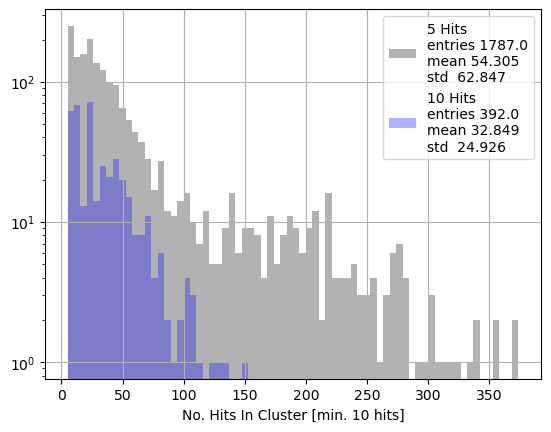

In [23]:
pltext.hist(nO_clusters_signal_5hits, 70, xylabels="No. Hits In Cluster [min. 10 hits]", histtype="stepfilled", alpha=0.3, ylog=True, range=(np.sort(nO_clusters_signal_5hits)[0], np.sort(nO_clusters_signal_5hits)[-1]), label="5 Hits ");
pltext.hist(nO_clusters_signal_10hits,70, xylabels="No. Hits In Cluster [min. 10 hits]", histtype="stepfilled", alpha=0.3, ylog=True, range=(np.sort(nO_clusters_signal_5hits)[0], np.sort(nO_clusters_signal_5hits)[-1]), label="10 Hits");

In [63]:
n_10hits_bkg = n

In [64]:
m_10hits = [len(i[0]) for i in n_10hits]
m_5hits = [len(i[0]) for i in n_5hits]
m_10hits_bkg = [len(i[0]) for i in n_10hits_bkg]

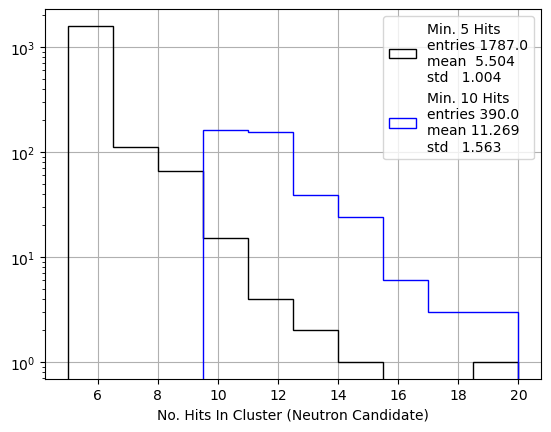

In [67]:
pltext.hist(m_5hits,  10, xylabels="No. Hits In Cluster (Neutron Candidate)", range=(5,20), ylog=True, label="Min. 5 Hits");
pltext.hist(m_10hits, 10, xylabels="No. Hits In Cluster (Neutron Candidate)", range=(5,20), ylog=True, label="Min. 10 Hits");

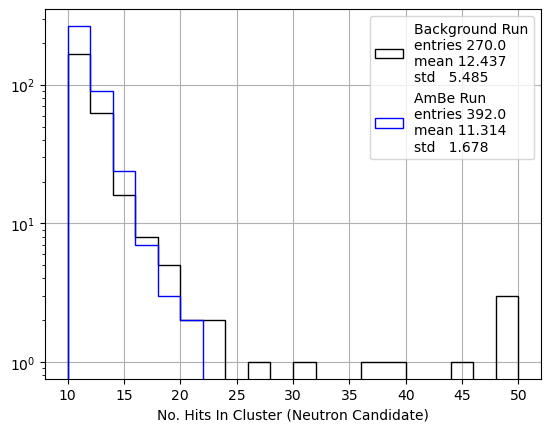

In [72]:
pltext.hist(m_10hits_bkg, 20, xylabels="No. Hits In Cluster (Neutron Candidate)", range=(10,50), ylog=True, label="Background Run");
pltext.hist(m_10hits,     20, xylabels="No. Hits In Cluster (Neutron Candidate)", range=(10,50), ylog=True, label="AmBe Run");